In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tqdm import tqdm, tqdm_notebook

## Complex NAC Layer

$y=\exp [W(\log(|x|+\varepsilon))]$

### Multiplication

**Creating training data**

In [2]:
np.random.seed(42)

In [3]:
# Generate a series of input number X1 and X2 for training
x1 = np.random.randint(low=0, high=10000, size=1000)
x1 = x1.astype('float32')
x2 = np.random.randint(low=100, high=10000, size=1000)
x2 = x2.astype('float32')

In [4]:
print(len(x1), len(x2))

1000 1000


In [5]:
y_train = x1*x2

In [6]:
y_train.dtype

dtype('float32')

In [7]:
x_train = np.column_stack((x1,x2))

In [8]:
print(x_train.shape)
print(y_train.shape)

(1000, 2)
(1000,)


**Creating testing data**

In [9]:
# Generate a series of input number X1 and X2 for testing
x1 = np.random.randint(low=0, high=10000, size=100)
x1 = x1.astype('float32')
x2 = np.random.randint(low=100, high=10000, size=100)
x2 = x2.astype('float32')

In [10]:
x_test = np.column_stack((x1,x2))
y_test = x1*x2

In [11]:
print(x_test.shape)
print(y_test.shape)

(100, 2)
(100,)


**Loss Function**

Using RMSE as a loss function

In [12]:
def rmsle_loss(predicted_y, target_y):
    predicted_y = tf.squeeze(predicted_y)
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log(predicted_y) - tf.math.log(target_y))))

In [13]:
def rmse_loss(predicted_y, target_y):
    return tf.sqrt(tf.reduce_mean(tf.square(predicted_y - target_y)))

**Modelling**

In [14]:
n_epochs = 5000
alpha = 0.1
epsilon = 0.000001

In [15]:
W_hat = tf.Variable(shape=[2, 1],
                        initial_value=tf.random.uniform(shape=[2, 1], minval=-2, maxval=2),
                        trainable=True, name="W_hat")
M_hat = tf.Variable(shape=[2, 1],
                        initial_value=tf.random.uniform(shape=[2, 1], minval=-2, maxval=2),
                        trainable=True, name="M_hat")

In [16]:
optimize = tf.keras.optimizers.Adam(learning_rate=alpha)

In [17]:
W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
# Express input feature in log space to learn complex functions
x_modified = tf.math.log(tf.abs(x_train) + epsilon)
y_pred = tf.exp(tf.matmul(x_modified, W))
print(f"RMSE Loss: {rmse_loss(y_pred, y_train)}")
print(f"RMSLE Loss: {rmsle_loss(y_pred, y_train):.2f}")

RMSE Loss: 33640916.0
RMSLE Loss: 14.38


In [18]:
loss_history = []

In [19]:
def train(X, y, learning_rate=0.01):
    with tf.GradientTape() as t:
        # update weight matrix (W) -> restricted to [-1, 1]
        W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
        # express input feature in log space to learn complex functions
        x_modified = tf.math.log(tf.abs(X) + epsilon)
        # make prediction
        y_pred = tf.exp(tf.matmul(x_modified, W))
        # calculate both loss
        rmsle = rmsle_loss(y_pred, y)
        rmse = rmse_loss(y_pred, y)
    # calculate gradient w.r.t rmsle loss
    dW_hat, dM_hat = t.gradient(rmsle, (W_hat, M_hat))
    optimize.apply_gradients(zip([dW_hat, dM_hat], [W_hat, M_hat]))
    return rmsle, rmse

**Looping**

In [20]:
y_train = y_train.astype('float32')

In [21]:
for epoch in range(n_epochs):
    rmsle, rmse = train(x_train, y_train)
    loss_history.append(rmsle)
    if epoch%500==0:
        print(f"Epoch: {epoch}\tRMSE Loss: {rmse:.2f}\tRMSLE Loss: {rmsle:.2f}")

Epoch: 0	RMSE Loss: 33640916.00	RMSLE Loss: 14.38
Epoch: 500	RMSE Loss: 30705406.00	RMSLE Loss: 0.02
Epoch: 1000	RMSE Loss: 30938534.00	RMSLE Loss: 0.01
Epoch: 1500	RMSE Loss: 30999058.00	RMSLE Loss: 0.00
Epoch: 2000	RMSE Loss: 31024222.00	RMSLE Loss: 0.00
Epoch: 2500	RMSE Loss: 31037202.00	RMSLE Loss: 0.00
Epoch: 3000	RMSE Loss: 31044764.00	RMSLE Loss: 0.00
Epoch: 3500	RMSE Loss: 31049558.00	RMSLE Loss: 0.00
Epoch: 4000	RMSE Loss: 31052750.00	RMSLE Loss: 0.00
Epoch: 4500	RMSE Loss: 31054966.00	RMSLE Loss: 0.00


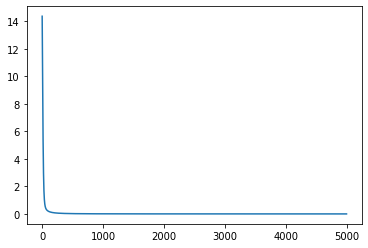

In [22]:
plt.plot(loss_history)

**Testing**

In [23]:
def get_pred(X):
    W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
    x_modified = tf.math.log(tf.abs(X) + epsilon)
    y_pred = tf.exp(tf.matmul(x_modified, W))
    return y_pred

In [24]:
y_test_pred = get_pred(x_test)

In [25]:
y_test_pred.shape

TensorShape([100, 1])

Test Data

In [26]:
for i in range(len(x_test))[:100]:
    print(f"Input: {x_test[i]}\tOutput: {y_test_pred[i].numpy()[0]:.2f}\tActual: {y_test[i]}")

Input: [9732. 6506.]	Output: 63297476.00	Actual: 63316392.0
Input: [6099. 8691.]	Output: 52990720.00	Actual: 53006408.0
Input: [8555. 7007.]	Output: 59927016.00	Actual: 59944884.0
Input: [2368. 8900.]	Output: 21069288.00	Actual: 21075200.0
Input: [ 285. 1738.]	Output: 495221.56	Actual: 495330.0
Input: [ 148. 5771.]	Output: 853913.50	Actual: 854108.0
Input: [4037. 7028.]	Output: 28363942.00	Actual: 28372036.0
Input: [6549. 1482.]	Output: 9703021.00	Actual: 9705618.0
Input: [7121. 1503.]	Output: 10699985.00	Actual: 10702863.0
Input: [9958. 9111.]	Output: 90699544.00	Actual: 90727336.0
Input: [4895. 3392.]	Output: 16599255.00	Actual: 16603840.0
Input: [5280. 9111.]	Output: 48091948.00	Actual: 48106080.0
Input: [1012.  519.]	Output: 525112.94	Actual: 525228.0
Input: [9715. 4617.]	Output: 44840992.00	Actual: 44854156.0
Input: [2785. 3402.]	Output: 9472034.00	Actual: 9474570.0
Input: [3725. 7957.]	Output: 29631360.00	Actual: 29639824.0
Input: [4576. 9800.]	Output: 44831584.00	Actual: 4484480

Training Data

In [27]:
y_train_pred = get_pred(x_train)

In [28]:
for i in range(100):
    print(f"Input: {x_train[i]}\tOutput: {y_train_pred[i].numpy()[0]:.2f}\tActual: {y_train[i]}\tAbsolute Difference: {tf.math.abs(y_train_pred[i]-y_train[i])[0]:.2f}")

Input: [7270. 9931.]	Output: 72176664.00	Actual: 72198368.0	Absolute Difference: 21704.00
Input: [860. 927.]	Output: 797039.31	Actual: 797220.0	Absolute Difference: 180.69
Input: [5390. 3631.]	Output: 19565606.00	Actual: 19571090.0	Absolute Difference: 5484.00
Input: [5191. 7247.]	Output: 37608240.00	Actual: 37619176.0	Absolute Difference: 10936.00
Input: [5734. 4551.]	Output: 26088058.00	Actual: 26095434.0	Absolute Difference: 7376.00
Input: [6265. 3976.]	Output: 24902612.00	Actual: 24909640.0	Absolute Difference: 7028.00
Input: [ 466. 6059.]	Output: 2822797.75	Actual: 2823494.0	Absolute Difference: 696.25
Input: [4426.  226.]	Output: 1000046.00	Actual: 1000276.0	Absolute Difference: 230.00
Input: [5578. 3277.]	Output: 18274024.00	Actual: 18279106.0	Absolute Difference: 5082.00
Input: [8322. 8895.]	Output: 74001968.00	Actual: 74024192.0	Absolute Difference: 22224.00
Input: [1685. 6124.]	Output: 10316152.00	Actual: 10318940.0	Absolute Difference: 2788.00
Input: [ 769. 5209.]	Output: 40

In [29]:
for i in range(100):
    print(f"Input: {x_train[i]}\tOutput: {y_train_pred[i].numpy()[0]:.2f}\tActual: {y_train[i]}\tAbsolute Difference: {tf.math.abs(y_train_pred[i]-y_train[i])[0]:.2f}")

Input: [7270. 9931.]	Output: 72176664.00	Actual: 72198368.0	Absolute Difference: 21704.00
Input: [860. 927.]	Output: 797039.31	Actual: 797220.0	Absolute Difference: 180.69
Input: [5390. 3631.]	Output: 19565606.00	Actual: 19571090.0	Absolute Difference: 5484.00
Input: [5191. 7247.]	Output: 37608240.00	Actual: 37619176.0	Absolute Difference: 10936.00
Input: [5734. 4551.]	Output: 26088058.00	Actual: 26095434.0	Absolute Difference: 7376.00
Input: [6265. 3976.]	Output: 24902612.00	Actual: 24909640.0	Absolute Difference: 7028.00
Input: [ 466. 6059.]	Output: 2822797.75	Actual: 2823494.0	Absolute Difference: 696.25
Input: [4426.  226.]	Output: 1000046.00	Actual: 1000276.0	Absolute Difference: 230.00
Input: [5578. 3277.]	Output: 18274024.00	Actual: 18279106.0	Absolute Difference: 5082.00
Input: [8322. 8895.]	Output: 74001968.00	Actual: 74024192.0	Absolute Difference: 22224.00
Input: [1685. 6124.]	Output: 10316152.00	Actual: 10318940.0	Absolute Difference: 2788.00
Input: [ 769. 5209.]	Output: 40

### Division

**Creating training data**

In [30]:
np.random.seed(42)

In [31]:
# Generate a series of input number X1 and X2 for training
x1 = np.random.randint(low=0, high=10000, size=1000)
x1 = x1.astype('float32')
x2 = np.random.randint(low=100, high=10000, size=1000)
x2 = x2.astype('float32')

In [32]:
y_train = x1/x2

In [33]:
x_train = np.column_stack((x1,x2))

In [34]:
print(x_train.shape)
print(y_train.shape)

(1000, 2)
(1000,)


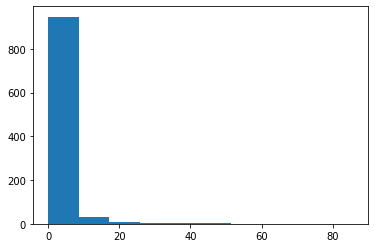

In [35]:
_ = plt.hist(y_train)

Majority of y lies between 0 & 20

**Creating testing data**

In [36]:
# Generate a series of input number X1 and X2 for testing
x1 = np.random.randint(low=0, high=10000, size=100)
x1 = x1.astype('float32')
x2 = np.random.randint(low=100, high=10000, size=100)
x2 = x2.astype('float32')

In [37]:
x_test = np.column_stack((x1,x2))
y_test = x1/x2

In [38]:
print(x_test.shape)
print(y_test.shape)

(100, 2)
(100,)


**Modelling**

In [39]:
n_epochs = 10000
alpha = 0.1
epsilon = 0.000001

In [40]:
W_hat = tf.Variable(shape=[2, 1],
                        initial_value=tf.random.uniform(shape=[2, 1], minval=-2, maxval=2),
                        trainable=True, name="W_hat")
M_hat = tf.Variable(shape=[2, 1],
                        initial_value=tf.random.uniform(shape=[2, 1], minval=-2, maxval=2),
                        trainable=True, name="M_hat")

In [41]:
optimize = tf.keras.optimizers.Adam(learning_rate=alpha)

In [42]:
W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
# Express input feature in log space to learn complex functions
x_modified = tf.math.log(tf.abs(x_train) + epsilon)
y_pred = tf.exp(tf.matmul(x_modified, W))
print(f"RMSE Loss: {rmse_loss(y_pred, y_train)}")
print(f"RMSLE Loss: {rmsle_loss(y_pred, y_train):.2f}")

RMSE Loss: 11.852006912231445
RMSLE Loss: 2.85


In [43]:
loss_history = []

In [44]:
def train(X, y, learning_rate=0.01):
    with tf.GradientTape() as t:
        # update weight matrix (W) -> restricted to [-1, 1]
        W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
        # express input feature in log space to learn complex functions
        x_modified = tf.math.log(tf.abs(X) + epsilon)
        # make prediction
        y_pred = tf.exp(tf.matmul(x_modified, W))
        # calculate both loss
        rmsle = rmsle_loss(y_pred, y)
        rmse = rmse_loss(y_pred, y)
    # calculate gradient w.r.t rmsle loss
    dW_hat, dM_hat = t.gradient(rmsle, (W_hat, M_hat))
    optimize.apply_gradients(zip([dW_hat, dM_hat], [W_hat, M_hat]))
    return rmsle, rmse

**Looping**

In [45]:
y_train = y_train.astype('float32')

In [46]:
for epoch in range(n_epochs):
    rmsle, rmse = train(x_train, y_train)
    loss_history.append(rmsle)
    if epoch%500==0:
        print(f"Epoch: {epoch}\tRMSE Loss: {rmse:.2f}\tRMSLE Loss: {rmsle}")

Epoch: 0	RMSE Loss: 11.85	RMSLE Loss: 2.8488261699676514
Epoch: 500	RMSE Loss: 8.57	RMSLE Loss: 0.005965225864201784
Epoch: 1000	RMSE Loss: 8.62	RMSLE Loss: 0.0018308021826669574
Epoch: 1500	RMSE Loss: 8.63	RMSLE Loss: 0.0009020435390993953
Epoch: 2000	RMSE Loss: 8.63	RMSLE Loss: 0.0005307287792675197
Epoch: 2500	RMSE Loss: 8.63	RMSLE Loss: 0.0003425833419896662
Epoch: 3000	RMSE Loss: 8.64	RMSLE Loss: 0.0002339521743124351
Epoch: 3500	RMSE Loss: 8.64	RMSLE Loss: 0.00016538774070795625
Epoch: 4000	RMSE Loss: 8.64	RMSLE Loss: 0.00012001246068393812
Epoch: 4500	RMSE Loss: 8.64	RMSLE Loss: 8.859192894306034e-05
Epoch: 5000	RMSE Loss: 8.64	RMSLE Loss: 6.637765909545124e-05
Epoch: 5500	RMSE Loss: 8.64	RMSLE Loss: 5.018784577259794e-05
Epoch: 6000	RMSE Loss: 8.64	RMSLE Loss: 3.81501522497274e-05
Epoch: 6500	RMSE Loss: 8.64	RMSLE Loss: 2.9216074835858308e-05
Epoch: 7000	RMSE Loss: 8.64	RMSLE Loss: 2.2349351638695225e-05
Epoch: 7500	RMSE Loss: 8.64	RMSLE Loss: 1.7331854905933142e-05
Epoch: 8000

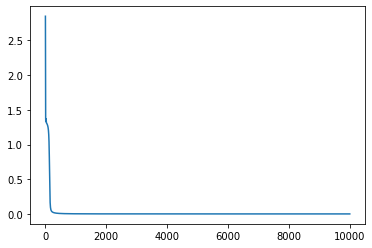

In [47]:
plt.plot(loss_history)

**Testing**

In [48]:
def get_pred(X):
    W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
    x_modified = tf.math.log(tf.abs(X) + epsilon)
    y_pred = tf.exp(tf.matmul(x_modified, W))
    return y_pred

In [49]:
y_test_pred = get_pred(x_test)

In [50]:
y_test_pred.shape

TensorShape([100, 1])

Test Data

In [51]:
for i in range(len(x_test))[:100]:
    print(f"Input: {x_test[i]}\tOutput: {y_test_pred[i].numpy()[0]:.2f}\tActual: {y_test[i]:.2f}")

Input: [9732. 6506.]	Output: 1.50	Actual: 1.50
Input: [6099. 8691.]	Output: 0.70	Actual: 0.70
Input: [8555. 7007.]	Output: 1.22	Actual: 1.22
Input: [2368. 8900.]	Output: 0.27	Actual: 0.27
Input: [ 285. 1738.]	Output: 0.16	Actual: 0.16
Input: [ 148. 5771.]	Output: 0.03	Actual: 0.03
Input: [4037. 7028.]	Output: 0.57	Actual: 0.57
Input: [6549. 1482.]	Output: 4.42	Actual: 4.42
Input: [7121. 1503.]	Output: 4.74	Actual: 4.74
Input: [9958. 9111.]	Output: 1.09	Actual: 1.09
Input: [4895. 3392.]	Output: 1.44	Actual: 1.44
Input: [5280. 9111.]	Output: 0.58	Actual: 0.58
Input: [1012.  519.]	Output: 1.95	Actual: 1.95
Input: [9715. 4617.]	Output: 2.10	Actual: 2.10
Input: [2785. 3402.]	Output: 0.82	Actual: 0.82
Input: [3725. 7957.]	Output: 0.47	Actual: 0.47
Input: [4576. 9800.]	Output: 0.47	Actual: 0.47
Input: [5782. 7970.]	Output: 0.73	Actual: 0.73
Input: [6257. 5793.]	Output: 1.08	Actual: 1.08
Input: [9793.  867.]	Output: 11.30	Actual: 11.30
Input: [2408. 2144.]	Output: 1.12	Actual: 1.12
Input: [ 34

Training Data

In [52]:
y_train_pred = get_pred(x_train)

In [53]:
for i in range(100):
    print(f"Input: {x_train[i]}\tOutput: {y_train_pred[i].numpy()[0]:.2f}\tActual: {y_train[i]:.2f}")

Input: [7270. 9931.]	Output: 0.73	Actual: 0.73
Input: [860. 927.]	Output: 0.93	Actual: 0.93
Input: [5390. 3631.]	Output: 1.48	Actual: 1.48
Input: [5191. 7247.]	Output: 0.72	Actual: 0.72
Input: [5734. 4551.]	Output: 1.26	Actual: 1.26
Input: [6265. 3976.]	Output: 1.58	Actual: 1.58
Input: [ 466. 6059.]	Output: 0.08	Actual: 0.08
Input: [4426.  226.]	Output: 19.58	Actual: 19.58
Input: [5578. 3277.]	Output: 1.70	Actual: 1.70
Input: [8322. 8895.]	Output: 0.94	Actual: 0.94
Input: [1685. 6124.]	Output: 0.28	Actual: 0.28
Input: [ 769. 5209.]	Output: 0.15	Actual: 0.15
Input: [6949. 4246.]	Output: 1.64	Actual: 1.64
Input: [2433. 7296.]	Output: 0.33	Actual: 0.33
Input: [5311. 3468.]	Output: 1.53	Actual: 1.53
Input: [5051. 3897.]	Output: 1.30	Actual: 1.30
Input: [6420. 1892.]	Output: 3.39	Actual: 3.39
Input: [1184. 5832.]	Output: 0.20	Actual: 0.20
Input: [4555. 3576.]	Output: 1.27	Actual: 1.27
Input: [3385. 3517.]	Output: 0.96	Actual: 0.96
Input: [6396. 1745.]	Output: 3.67	Actual: 3.67
Input: [8666.

### Testing out of range

In the training set both *x1 & x2* were random numbers within **0-10000**. Let's again create another test set with *x1* between **50000-100000** & *x2* from **-100 to 0** i.e negative numbers. This will definitely be different then the training set

In [54]:
# numerator will be between 50000-100000
x1 = np.random.randint(low=50000, high=100000, size=100)
x1 = x1.astype('float32')
# denominator will be between -100 to 0
x2 = np.random.randint(low=-100, high=0, size=100)
x2 = x2.astype('float32')

x_test = np.column_stack((x1,x2))
y_test = x1/x2

In [55]:
print(f"Min: {min(y_test)}\tMax: {max(y_test)}")

Min: -30912.0	Max: -606.550537109375


In [56]:
y_test_pred = get_pred(x_test)

In [57]:
for i in range(len(x_test))[:100]:
    print(f"Input: {x_test[i]}\tOutput: {y_test_pred[i].numpy()[0]:.2f}\tActual: {y_test[i]:.2f}")

Input: [ 6.6531e+04 -5.1000e+01]	Output: 1304.50	Actual: -1304.53
Input: [ 7.2804e+04 -6.0000e+00]	Output: 12133.59	Actual: -12134.00
Input: [ 7.8903e+04 -2.2000e+01]	Output: 3586.40	Actual: -3586.50
Input: [ 9.4857e+04 -7.8000e+01]	Output: 1216.08	Actual: -1216.12
Input: [ 6.0142e+04 -1.3000e+01]	Output: 4626.17	Actual: -4626.31
Input: [ 9.9517e+04 -5.7000e+01]	Output: 1745.87	Actual: -1745.91
Input: [ 9.8355e+04 -2.4000e+01]	Output: 4098.00	Actual: -4098.12
Input: [59866.   -79.]	Output: 757.78	Actual: -757.80
Input: [54531.   -58.]	Output: 940.17	Actual: -940.19
Input: [ 9.5454e+04 -6.4000e+01]	Output: 1491.43	Actual: -1491.47
Input: [ 8.8098e+04 -4.0000e+01]	Output: 2202.39	Actual: -2202.45
Input: [ 8.8278e+04 -4.0000e+00]	Output: 22068.71	Actual: -22069.50
Input: [ 7.8138e+04 -4.5000e+01]	Output: 1736.35	Actual: -1736.40
Input: [77065.   -98.]	Output: 786.36	Actual: -786.38
Input: [ 7.9956e+04 -3.8000e+01]	Output: 2104.05	Actual: -2104.11
Input: [ 9.1732e+04 -8.2000e+01]	Output: 1

**The absolute value are approximately correct, however, it couldn't predict negative values as there were no negative values in the training data**